## Association between gene expression and subtype or grade
### (Brain Lower Grade Glioma) 

In [1]:
import numpy as np 
import pandas as pd 
import scanpy as sc 
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

sc.settings.verbosity = 3 

sc.settings.set_figure_params(dpi = 80)
%matplotlib inline

## Gene Data Preprocessing

In [176]:
# read the gene expression data: 
raw_data_rna = pd.read_table("./data/data_mrna_seq_v2_rsem.txt", sep="\t")
raw_data_rna.head(3)

,Hugo_Symbol,Entrez_Gene_Id,TCGA-CS-4938-01,TCGA-CS-4941-01,TCGA-CS-4942-01,TCGA-CS-4943-01,TCGA-CS-4944-01,TCGA-CS-5390-01,TCGA-CS-5393-01,TCGA-CS-5394-01,...,TCGA-VW-A8FI-01,TCGA-W9-A837-01,TCGA-WH-A86K-01,TCGA-WY-A858-01,TCGA-WY-A859-01,TCGA-WY-A85A-01,TCGA-WY-A85B-01,TCGA-WY-A85C-01,TCGA-WY-A85D-01,TCGA-WY-A85E-01
0,NaN,100130426,-6.6197,-6.6197,-6.6197,-6.6197,-6.6197,-6.6197,-6.6197,-6.6197,...,-6.6197,-6.6197,-6.6197,-6.6197,-6.6197,-6.6197,-6.6197,-6.6197,-6.6197,-6.6197
1,NaN,100133144,0.1185,2.0342,0.5116,0.1034,-3.1094,-0.4877,-0.8870,0.0577,...,1.1529,0.5938,0.4161,-0.0182,-1.0264,-0.4623,0.0507,0.4778,-0.4763,0.2876
2,UBE2Q2P2,100134869,0.8030,0.6853,-0.3650,-1.5341,1.2744,1.1389,-0.7295,0.1724,...,0.7471,1.0861,0.0440,0.2981,-0.4821,0.2481,0.5676,0.4846,-0.6968,-0.9707
3,HMGB1P1,10357,1.9096,0.2687,0.7763,1.9239,1.2506,0.3278,0.9837,1.1387,...,-0.3517,-0.8943,1.0942,0.7643,-0.4045,-0.4197,-0.2125,-0.5183,-0.8822,-0.0090
4,NaN,10431,1.1627,-1.7875,-0.0135,1.1169,1.0094,-0.2972,-0.4659,-0.0976,...,-0.3810,-0.1261,-0.3370,0.7580,1.2928,0.2058,0.2314,-0.6588,0.4685,0.6967
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20526,ZYG11A,440590,-1.2143,-0.7410,-0.7399,1.0996,-0.5623,-1.2143,-1.2143,-0.7535,...,0.7317,-1.2143,-1.2143,-0.4660,0.1100,-1.2143,-0.2231,0.9422,-1.2143,1.1519
20527,ZYG11B,79699,0.4502,0.9028,0.6187,0.9174,-0.1225,-0.5221,0.7301,0.2655,...,-1.3630,0.1147,0.0871,-0.9503,0.8521,0.4425,0.3485,1.0692,-0.1277,0.7383
20528,ZYX,7791,-0.8102,0.9552,-0.1635,-0.2393,-0.6971,-0.4111,-0.6320,-0.5666,...,2.3670,-1.0349,-0.1840,0.3662,-0.4420,-0.9402,-0.8402,-0.4389,-0.6813,-0.3227
20529,ZZEF1,23140,-1.2280,0.1514,-0.5145,0.5748,-2.9617,0.8971,0.6922,1.3182,...,-1.7330,0.2662,-0.5119,-0.9516,-0.6513,-0.1893,0.1042,0.7413,-0.5001,-0.4875


In [177]:
# choosing Entrez_Gene_Id as column because: 
print(f"There are {len(raw_data_rna[raw_data_rna.Entrez_Gene_Id.isna()])} genes has no ids")
print("we would use Entrez_Gene_Id as name of gene with a correponding dictionary table")
gene_symbol_id = raw_data_rna.iloc[:,:2].copy()
gene_symbol_id.tail(3)

There are 0 genes has no ids
we would use Entrez_Gene_Id as name of gene with a correponding dictionary table


,Hugo_Symbol,Entrez_Gene_Id
20528,ZYX,7791
20529,ZZEF1,23140
20530,ZZZ3,26009


In [178]:
# transpose the data and make the gene id as the column names: 
df_clean = raw_data_rna.set_index("Entrez_Gene_Id").drop("Hugo_Symbol", axis = 1).transpose()
print(f"There are {len(df_clean)} samples in total, and there are {len(df_clean.columns)} genes in total.")

There are 514 samples in total, and there are 20531 genes in total.


In [179]:
# check the quality of the data: 
# 1) if there is any NA data
print(f"If there is NA values: {df_clean.isnull().values.any()}")

# 2) if there are columns with all the same value
unique_counts = df_clean.nunique()
same_value_cols = unique_counts[unique_counts == 1].index.tolist()
print(f"There are {len(same_value_cols)} columns with the same value.")
print(f"{same_value_cols[0:10]}...")

If there is NA values: True
There are 0 columns with the same value.
[]...


In [20]:
# thus, we need to drop all of same_value_cols: 
df_clean_1 = df_clean.drop(same_value_cols, axis = 1)
df_clean_1 = df_clean_1.T.drop_duplicates().T
df_clean_1.columns = df_clean_1.columns.astype("str")

In [21]:
len(df_clean_1.columns)

20213

normalizing counts per cell
    finished (0:00:00)


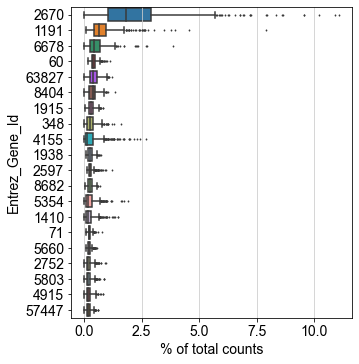

In [22]:
adata_gene = sc.AnnData(df_clean_1)
sc.pl.highest_expr_genes(adata_gene, n_top=20, )
#Show those genes that yield the highest fraction of counts in each single cell, across all cells.

## Clinical Patient Data Preprocessing

In [23]:
## read patient data and preprocessing...
raw_data_sample = pd.read_table("./data/data_clinical_sample.txt", sep="\t")
df_sample2 = pd.read_table("./supplement_data/Clinical_Data.tsv", sep="\t")
raw_data_sample.columns = raw_data_sample.iloc[3,:]
raw_data_sample = raw_data_sample.drop([0,1,2,3], axis = 0)
df_patient = raw_data_sample.reset_index().drop(["index"], axis = 1)
df_full = df_patient.merge(df_sample2, left_on = "PATIENT_ID", right_on = "Patient ID", how = "left")
df_full_1 = df_full.drop(['Patient ID', 'Sample ID','Cancer Type Detailed','Tumor Type', 'Aneuploidy Score'], axis = 1)

In [24]:
df_full_1

,PATIENT_ID,SAMPLE_ID,ONCOTREE_CODE,CANCER_TYPE,CANCER_TYPE_DETAILED,TUMOR_TYPE,GRADE,TISSUE_PROSPECTIVE_COLLECTION_INDICATOR,TISSUE_RETROSPECTIVE_COLLECTION_INDICATOR,TISSUE_SOURCE_SITE_CODE,...,MSI MANTIS Score,MSIsensor Score,Overall Survival Status,Sex,Ethnicity Category,Race Category,Subtype,Birth from Initial Pathologic Diagnosis Date,Buffa Hypoxia Score,Somatic Status
0,TCGA-CS-4938,TCGA-CS-4938-01,DIFG,Glioma,Astrocytoma,Astrocytoma,G2,No,Yes,CS,...,0.3030,0.00,0:LIVING,Female,Not Hispanic Or Latino,White,LGG_IDHmut-non-codel,-11509.0,-27,Matched
1,TCGA-CS-4941,TCGA-CS-4941-01,DIFG,Glioma,Astrocytoma,Astrocytoma,G3,No,Yes,CS,...,0.2736,0.00,1:DECEASED,Male,Not Hispanic Or Latino,White,LGG_IDHwt,-24578.0,-33,Matched
2,TCGA-CS-4942,TCGA-CS-4942-01,DIFG,Glioma,Astrocytoma,Astrocytoma,G3,No,Yes,CS,...,0.2810,0.02,1:DECEASED,Female,NaN,Black or African American,LGG_IDHmut-non-codel,-16297.0,-27,Matched
3,TCGA-CS-4943,TCGA-CS-4943-01,DIFG,Glioma,Astrocytoma,Astrocytoma,G3,No,Yes,CS,...,0.2751,0.25,1:DECEASED,Male,NaN,White,LGG_IDHmut-non-codel,-13565.0,-11,Matched
4,TCGA-CS-4944,TCGA-CS-4944-01,DIFG,Glioma,Astrocytoma,Astrocytoma,G2,No,Yes,CS,...,0.2697,0.04,0:LIVING,Male,NaN,White,LGG_IDHmut-non-codel,-18494.0,-11,Matched
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
509,TCGA-WY-A85B,TCGA-WY-A85B-01,DIFG,Glioma,Astrocytoma,Astrocytoma,G2,No,Yes,WY,...,0.3309,0.03,0:LIVING,Male,NaN,White,LGG_IDHmut-non-codel,-8817.0,-23,Matched
510,TCGA-WY-A85C,TCGA-WY-A85C-01,DIFG,Glioma,Astrocytoma,Astrocytoma,G2,No,Yes,WY,...,0.3184,0.04,0:LIVING,Male,NaN,White,LGG_IDHmut-non-codel,-13506.0,-23,Matched
511,TCGA-WY-A85D,TCGA-WY-A85D-01,OAST,Glioma,Oligoastrocytoma,Oligoastrocytoma,G2,No,Yes,WY,...,0.3142,0.00,0:LIVING,Male,NaN,White,LGG_IDHmut-non-codel,-21979.0,-23,Matched
512,TCGA-WY-A85E,TCGA-WY-A85E-01,OAST,Glioma,Oligoastrocytoma,Oligoastrocytoma,G2,No,Yes,WY,...,0.3171,0.00,0:LIVING,Female,NaN,White,LGG_IDHmut-non-codel,-17878.0,-19,Matched


## Creating anndata with sample as its obs:

In [25]:
df_sample_with_gene = df_clean_1.merge(df_full_1, left_index=True, right_on = "SAMPLE_ID")
X = df_sample_with_gene.iloc[:,0:-30].copy()
X = X.set_index("PATIENT_ID")
obs = df_sample_with_gene.iloc[:,-31:].copy()
obs = obs.set_index("PATIENT_ID")
adata_sample = sc.AnnData(X, obs = obs)

In [26]:
X = df_sample_with_gene.iloc[:,0:-30].copy()
X = X.set_index("PATIENT_ID")
obs = df_sample_with_gene.iloc[:,-31:].copy()
obs = obs.set_index("PATIENT_ID")
adata_sample = sc.AnnData(X, obs = obs)

In [27]:
sc.tl.pca(adata_sample, svd_solver = "arpack")

computing PCA
    with n_comps=50
    finished (0:00:01)


computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:01)


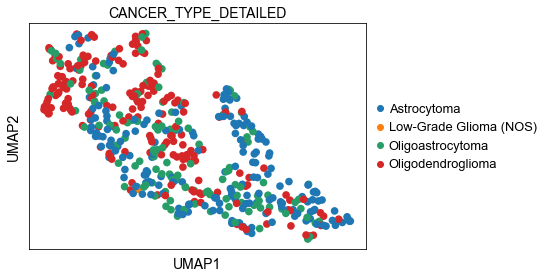

In [28]:
sc.pp.neighbors(adata_sample, n_neighbors=5)
sc.tl.umap(adata_sample, min_dist=0.3)
sc.pl.umap(adata_sample, color = ["CANCER_TYPE_DETAILED"])

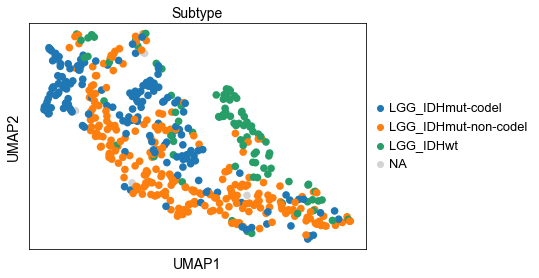

In [29]:
sc.pl.umap(adata_sample, color = ["Subtype"])

## TCGA researchers learned about lower grade glioma?

Reference: https://www.cancer.gov/about-nci/organization/ccg/research/structural-genomics/tcga/studied-cancers/glioma

Mutations and chromosomal alterations define three lower grade glioma subtypes with distinct clinical outcomes: 

1. IDH mutant and 1p/19q co-deletion:

* The 1p/19q abnormality consists of deletion of a short arm of chromosome 1 and longer arm of chromosome 19.

* Mutations in IDH1 and IDH2, isocitrate dehydrogenases, lead to abnormal enzyme activity, hypermethylation, and deviant gene expression.

* This subtype is associated with the most favorable prognosis.

2. IDH mutant without 1p/19q co-deletion, associated with intermediate prognosis



3. IDH wild-type, associated with the poorest outcomes

IDH wild-type subtype shares genomic markers and similar clinical outcomes with glioblastomas, indicating that this subtype of lower grade glioma may be a precursor to the more aggressive counterpart.


Molecular signatures and subtypes may inform the classification, diagnosis, and treatment of lower grade gliomas:

* Lower grade gliomas without IDH mutations may benefit from treatment with protocols adapted from current glioblastoma treatments.

* Recently developed therapies may target the aberrant activity of IDH1/2 proteins in lower grade glioma.


In [30]:
gene_symbol_id.loc[(gene_symbol_id.Hugo_Symbol == "IDH1") | (gene_symbol_id.Hugo_Symbol == "IDH2")]

,Hugo_Symbol,Entrez_Gene_Id
8233,IDH1,3417
8234,IDH2,3418


## Association between glioma subtype and gene expression? 

**Summary:**  

According to following models, we found that gene expression level would have highly correlation with the subtype of Brain Lower Grade Glioma. We could predict the subtype of BLGG based on the level of expression. 

In [31]:
# preprocessing the data: encode, drop nan, scale? 
X= pd.DataFrame(adata_sample.X)
X.columns = adata_sample.var_names
X.index = adata_sample.obs.index
y = adata_sample.obs['Subtype']
df = pd.concat([X,y], axis = 1)

In [33]:
df_drop = df.drop(df[df.Subtype.isnull()].index, axis = 0)

In [34]:
# assign features, target and encoding...
y = df_drop["Subtype"]
X= df_drop.drop("Subtype", axis = 1)

y = y.map({"LGG_IDHmut-non-codel":0, "LGG_IDHwt":1, "LGG_IDHmut-codel":2})

In [35]:
from sklearn.model_selection import train_test_split
X_train,X_test, y_train, y_test = train_test_split(X,y,random_state = 42)

In [36]:
print(f"There are totally {len(X_test)} samples in test set.")

There are totally 127 samples in test set.


In [107]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(penalty='l1', multi_class='multinomial', solver='saga')
clf.fit(X_train, y_train)

# get the model coefficients
coefficients = clf.coef_
intercept = clf.intercept_
y_pred = clf.predict(X_test)
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))
print("Train score", clf.score(X_train, y_train), "\nTest Score", clf.score(X_test, y_test))

              precision    recall  f1-score   support

           0       0.97      0.98      0.98        64
           1       1.00      0.90      0.95        21
           2       0.95      0.98      0.96        42

    accuracy                           0.97       127
   macro avg       0.97      0.96      0.96       127
weighted avg       0.97      0.97      0.97       127

Train score 0.9736842105263158 
Test Score 0.968503937007874


As the number of genes are enormous, while the sample size is always limited, one way to prevent overfitting is to prefilter the number of features (genes).

In [44]:
from sklearn.feature_selection import mutual_info_classif
# create a dataframe containing mutual information for each feature
midf = pd.DataFrame({
    "feature": X_train.columns.values,
    "mi": mutual_info_classif(X_train, y_train),
}).sort_values("mi", ascending=False)

In [46]:
midf.head()

,feature,mi
6266,54455,0.605651
15814,6429,0.574282
10266,10489,0.562355
18669,200081,0.557290
14193,5690,0.555381


With the MI between the target variable and each gene calculated, we will need to set a cutoff in terms of how many genes we would like to use in the model. There are two considerations: first, the training set only have 127 samples in test set, we do not want to use features that's larger than the samples as it tends to lead to overfitting or converging issue. Second, we should observe the distribution of the MIs from highest to lowest, trying to see if there is any sudden drop indicating the there might be a subset if features more informative than the others.

Therefore, let's sort the MIs and plot the top 400 to observe if there is such behavior.

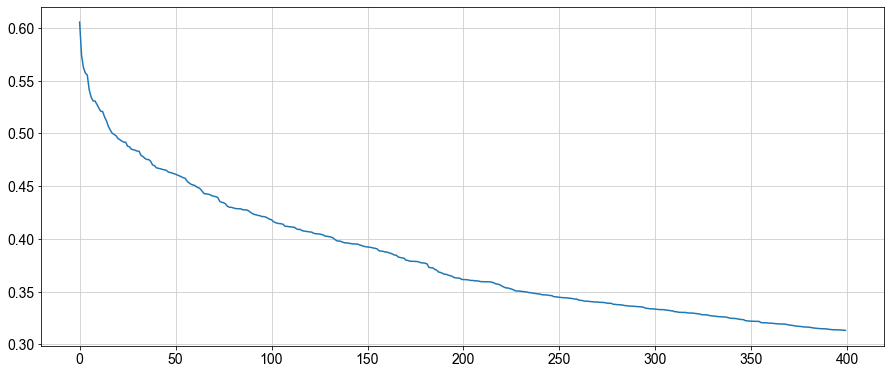

In [55]:
import matplotlib.pyplot as plt
import numpy as np
f, _ = plt.subplots(figsize = (15, 6))
plt.plot(np.arange(400), midf.mi.iloc[:400])

The biggest drops happens in around first 25 few features. However selecting < 25 features for ML models will likely lead to suboptimal outcome. we will set cutoff MI >= 0.40:

In [116]:
selected_genes = midf.loc[midf.mi >= 0.41, "feature"]
len(selected_genes)

113

In [117]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(penalty='l1', multi_class='multinomial', solver='saga')
clf.fit(X_train[selected_genes], y_train)

# get the model coefficients
coefficients = clf.coef_
intercept = clf.intercept_
y_pred = clf.predict(X_test[selected_genes])
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))
print("Train score", clf.score(X_train[selected_genes], y_train), "\nTest Score", clf.score(X_test[selected_genes], y_test))

              precision    recall  f1-score   support

           0       0.95      0.98      0.97        64
           1       0.95      0.90      0.93        21
           2       1.00      0.98      0.99        42

    accuracy                           0.97       127
   macro avg       0.97      0.96      0.96       127
weighted avg       0.97      0.97      0.97       127

Train score 0.9921052631578947 
Test Score 0.968503937007874


In [118]:
from sklearn.linear_model import LogisticRegression
import numpy as np

# set random seed for reproducibility
np.random.seed(4060)
lr = LogisticRegression(penalty='l1', multi_class='multinomial', solver='saga')
lr.fit(X_train[selected_genes], y_train)
lr.score(X_train[selected_genes], y_train)

0.9921052631578947

In [119]:
print("Train score", lr.score(X_train[selected_genes], y_train), "\nTest Score", lr.score(X_test[selected_genes], y_test))

Train score 0.9921052631578947 
Test Score 0.968503937007874


In [120]:
# the raw prediction values from predict_proba function are just scores the
# model predicted for each class

y_pred_score = lr.predict_proba(X_test[selected_genes])

# use predict function to directly ask model to output the
# predicted class

y_pred = lr.predict(X_test[selected_genes])

In [122]:
from sklearn.metrics import (accuracy_score, balanced_accuracy_score, 
                             roc_auc_score, f1_score)
def performance_scores(y_true, y_pred_score, y_pred=None):
    # find which class has the highest score as its predicted class
    if y_pred is None:
        y_pred = y_pred_score.argmax(axis=1)
        
    return {
        "accuracy": accuracy_score(y_true, y_pred),
        "balanced_accuracy": balanced_accuracy_score(y_true, y_pred),
        "auroc": roc_auc_score(y_true, y_pred_score, average="weighted",
                               multi_class="ovr"),
        "f1": f1_score(y_true, y_pred, average="weighted")
    }
performance_scores(y_test, y_pred_score, y_pred)

{'accuracy': 0.968503937007874,
 'balanced_accuracy': 0.955109126984127,
 'auroc': 0.9917468279839049,
 'f1': 0.9684107068388191}

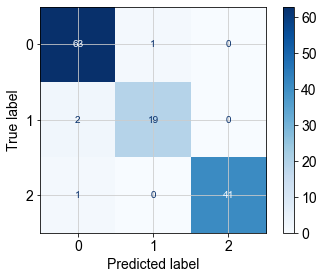

In [123]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=lr.classes_)
disp.plot(cmap="Blues")

In [146]:
df_gene_reference = pd.read_table("./supplement_data/gene_table.tsv")
df_gene_reference["NCBI GeneID"] = df_gene_reference["NCBI GeneID"].astype("str")

In [148]:
df_selected_genes = pd.DataFrame(selected_genes)
df_selected_genes = df_selected_genes.merge(df_gene_reference, left_on = "feature", right_on = "NCBI GeneID", how = "left")

In [167]:
df_selected_genes[df_selected_genes.feature == "10630"]

,feature,NCBI GeneID,Symbol,Description,Taxonomic Name,Gene Type,Gene Group Identifier,Gene Group Method
64,10630,10630,PDPN,podoplanin,Homo sapiens,PROTEIN_CODING,10630.0,NCBI Ortholog


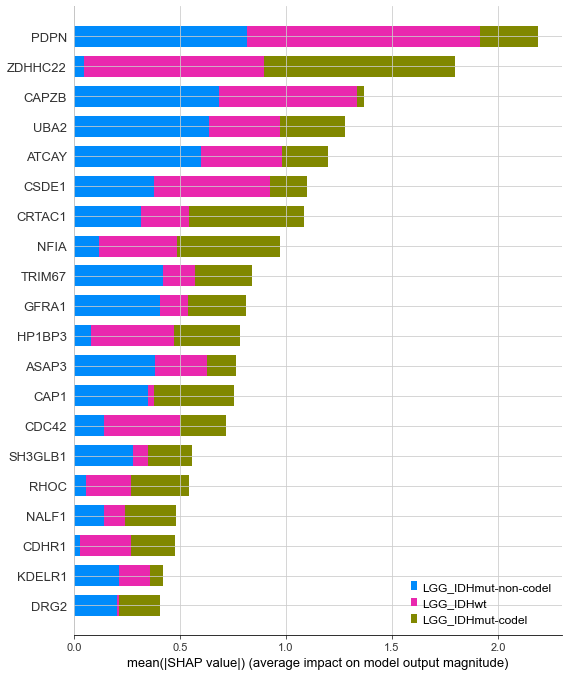

In [170]:
X_train = X_train[selected_genes]
X_test = X_test[selected_genes]

explainer = shap.Explainer(lr, X_train, feature_names=X.columns)
shap_values = explainer.shap_values(X_test)

# get the table for feature_importance
vals= np.abs(shap_values).mean(0)
feature_importance = pd.DataFrame(list(zip(X_train.columns, sum(vals))), columns=['gene_id','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'], ascending=False,inplace=True)
feature_importance = feature_importance.reset_index(drop=True)

# the plot for the data
class_names = ["LGG_IDHmut-non-codel", "LGG_IDHwt", "LGG_IDHmut-codel"]
shap.summary_plot(shap_values, X_train.values, plot_type="bar", class_names= class_names, feature_names = df_selected_genes.Symbol)

In [174]:
feature_importance.merge(df_selected_genes, how = "left", left_on = "gene_id", right_on = "feature").drop(["feature", "NCBI GeneID"], axis = 1)

,gene_id,feature_importance_vals,Symbol,Description,Taxonomic Name,Gene Type,Gene Group Identifier,Gene Group Method
0,10630,92.751961,PDPN,podoplanin,Homo sapiens,PROTEIN_CODING,10630.0,NCBI Ortholog
1,283576,76.093063,ZDHHC22,zinc finger DHHC-type palmitoyltransferase 22,Homo sapiens,PROTEIN_CODING,283576.0,NCBI Ortholog
2,832,57.873009,CAPZB,capping actin protein of muscle Z-line subunit...,Homo sapiens,PROTEIN_CODING,832.0,NCBI Ortholog
3,10054,54.095444,UBA2,ubiquitin like modifier activating enzyme 2,Homo sapiens,PROTEIN_CODING,10054.0,NCBI Ortholog
4,85300,50.798302,ATCAY,ATCAY kinesin light chain interacting caytaxin,Homo sapiens,PROTEIN_CODING,85300.0,NCBI Ortholog
...,...,...,...,...,...,...,...,...
108,79871,0.091790,RPAP2,RNA polymerase II associated protein 2,Homo sapiens,PROTEIN_CODING,79871.0,NCBI Ortholog
109,145837,0.080593,DRAIC,"downregulated RNA in cancer, inhibitor of cell...",Homo sapiens,ncRNA,NaN,NaN
110,4007,0.067834,PRICKLE3,prickle planar cell polarity protein 3,Homo sapiens,PROTEIN_CODING,4007.0,NCBI Ortholog
111,64802,0.061091,NMNAT1,nicotinamide nucleotide adenylyltransferase 1,Homo sapiens,PROTEIN_CODING,64802.0,NCBI Ortholog


## Gene clustering 
Compared two SHAP plots, found two models have different features in top rank. There might be some similarities in gene in expression. I am trying to assign genes into different groups as different metagenes with clustering methods and Non-negative Matrix Factorization, and plan to do hypothesis testing for the difference between subtypes for each subtype.

computing PCA
    with n_comps=50
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:17)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:17)
running Leiden clustering
    finished: found 21 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:09)


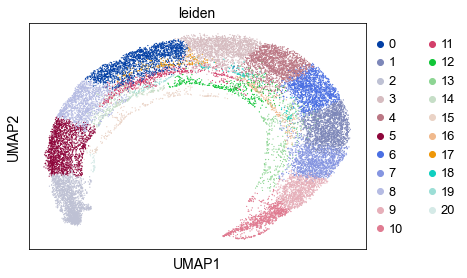

In [30]:
# can I use umap to cluster genes? 
df_gene = df_clean_1.transpose()
adata_gene = sc.AnnData(df_gene)
sc.tl.pca(adata_gene, svd_solver='arpack')
sc.pp.neighbors(adata_gene, n_neighbors=30, n_pcs=50)
sc.tl.umap(adata_gene, min_dist=0.3)
sc.tl.leiden(adata_gene)
sc.pl.umap(adata_gene, color = "leiden")

In [31]:
df_gene_cluster = adata_gene.obs
df_gene_cluster.groupby('leiden').leiden.count()

leiden
0     1933
1     1927
2     1900
3     1844
4     1822
5     1776
6     1591
7     1417
8     1375
9     1083
10     972
11     568
12     402
13     387
14     305
15     256
16     217
17     202
18     116
19      92
20      39
Name: leiden, dtype: int64

In [32]:
## NMF ... 
## .......

In [33]:
## Censensus clustering for gene??